In [1]:
from music21 import converter, instrument, note, chord, midi
import glob

import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *
from datetime import *

import keras
from keras.applications import *
import lightgbm as lgbm
import os
from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Lambda, Layer,Flatten, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose, LSTM
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dense
from music21 import instrument, note, stream, chord
import shutil
import collections
from collections import *
from keras import optimizers
import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from sklearn.utils import class_weight
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from os.path import isfile, join
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from skimage import morphology
from keras.utils import np_utils

from skimage import filters
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

Using TensorFlow backend.


https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [2]:
def printChord(c):
    print(f'{[x.nameWithOctave for x in c.pitches]} ({c.pitchedCommonName}), Root:{c.root()}, int:{c.intervalVector}, normalOrder:{c.normalOrder}')
    c.show()
    
def printNote(f):
    
    if f.name == 'rest':
        st = f'{f.name}'
    else:
        st = f'{f.name} {f.step} {f.octave} {f.pitch.french} {f.pitch} {f.pitch.frequency:0.2f}'
        if f.pitch.accidental:
            st = st +f' {f.pitch.accidental.name}-extra semi-tones:{f.pitch.accidental.alter}'
#     print(st)
    f.addLyric(st)
    return f.show()

def printPitch(p):
    print(f'{p} {p.nameWithOctave} {p.french} {p.octave} {p.frequency}')
    if p.accidental:
        print(f'{p.accidental} {p.accidental.name}-extra semi-tones:{p.accidental.alter}')

In [3]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        ;
#         self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.i = self.i+1
        
        if self.i%5 != 0:
            return
        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        ax = plt.figure(111)
        self.plotLosses(ax)
        plt.show()

    def plotLosses(self, ax):
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.val_losses)), self.val_losses, label="val loss")
        # ax.set_yscale("log", nonposy='clip')
        plt.legend()
        
basicLossPlot = PlotLosses()

In [4]:
from music21 import corpus

In [5]:
sequence_length = 100
n_vocab = 128
n_duration = 16

In [6]:
def readSong(s, maxtracks = -1, chordify = False, gatherRests=True, qlMult=4, qlMin=1, qlMax=16):
    # maxtracks=-1 returns 1 track with all elements combined one after the other, otherwise returns top X tracks
    # chordify toggles putting all parts together
    # gatherRests combines all rests into 1 (no more than 1 contiguous rest)
    # qlMult multiplies quarterLengths of notes/rests by that factor
    # qlMin/qlMax restricts note length
    
#     notes = np.zeros((0,n_vocab+(1+qlMax-qlMin)))
    notes = []
    
    if chordify == False:
        parts = s.parts
    else:
        parts = [s.chordify()]
    
    lastwasrest = False
    for p in parts:
        for element in p.recurse().notesAndRests:
            duration = int(element.duration.quarterLength *qlMult)
            duration = min(qlMax,max(qlMin,duration)) # don't want longer than whole or shorter than 16th
            ch = ''
            newnote = np.zeros(n_vocab+n_duration)
            
            if isinstance(element, note.Rest):
                nn = 0
                if lastwasrest == True and gatherRests == True:
                    continue # no need for multiple rests in this scenario
                lastwasrest = True
            elif isinstance(element, note.Note):
                lastwasrest = False
                nn = int(element.pitch.midi)+0
                newnote[nn] = 1
            elif isinstance(element, chord.Chord):
                lastwasrest = False
                for xxx in element.pitches:
                    newnote[xxx.midi] = 1

            newnote[n_vocab+int(duration)-1] = 1

            notes.append(newnote)
#             notes = np.concatenate([notes, newnote[newaxis,:]], axis=0)
            
    return np.stack(notes)

In [46]:
songs = []
count = 0
for i in tqdm(corpus.getComposer('bach', 'mxl')):
    s = corpus.parse(i)
    songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    
# F:\MLData\midi\Classical Archives - The Greats (MIDI)\Chopin

100%|██████████| 403/403 [00:13<00:00, 35.24it/s]


In [47]:
print(len(songs))
print(songs[0].shape)

403
(503, 144)


In [48]:
nn_inout = np.vstack(songs)
nn_inout.shape

(130387, 144)

# Second Model, PC

In [49]:
lookback = 32

In [50]:
from keras.layers import Concatenate, TimeDistributed

In [51]:
inp = Input(shape=(lookback,nn_inout.shape[1],))
x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256)(x)
x = Dropout(0.3)(x)
x = Dense(nn_inout.shape[1])(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 32, 144)       0                                            
____________________________________________________________________________________________________
lstm_10 (LSTM)                   (None, 32, 256)       410624      input_4[0][0]                    
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 32, 256)       0           lstm_10[0][0]                    
____________________________________________________________________________________________________
lstm_11 (LSTM)                   (None, 32, 512)       1574912     dropout_10[0][0]                 
___________________________________________________________________________________________

In [52]:
print('all data', nn_inout.shape)
print('lookback', lookback)
print('train', nn_inout[:-lookback].shape)
print('to predict', nn_inout[lookback:].shape)

all data (130387, 144)
lookback 32
train (130355, 144)
to predict (130355, 144)


In [53]:
# Add '0' at the end to make sure it fits blocks of 32
nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2.shape
nn_inout2 = nn_inout2.reshape(-1, lookback, 144)
nn_inout2.shape


(130400, 144)

(4075, 32, 144)

In [54]:
def cleanpred(pred, threshold=0.8):
    t = np.max(pred[:n_vocab])*threshold
    du = np.argmax(pred[n_vocab:])
    
#     print(np.where(pred[:n_vocab] > t))
    p2 = np.zeros(pred.shape)
    p2[np.where(pred[:n_vocab] > t)] = 1
    p2[n_vocab+du] = 1
    return p2

def predbitfieldtonote(pred, threshold=0.8):
    t = np.max(pred[:n_vocab])*threshold
    du = np.argmax(pred[n_vocab:])
    if np.argmax(pred)==0:
        n = note.Rest()
        n.duration.quarterLength = (du+1)/4
    else:
        nns = []
        for pp in np.where(pred[:n_vocab] > t)[0]:
            nn = note.Note()
            nn.pitch.midi = pp
            nns.append(nn)
        n = chord.Chord(nns)
        n.duration.quarterLength = (du+1)/4
    return n

def predtostream(pred):
    s = stream.Stream()
    for i in range(len(pred)):
        n = predbitfieldtonote(pred[i])
        s.append(n)
    return s

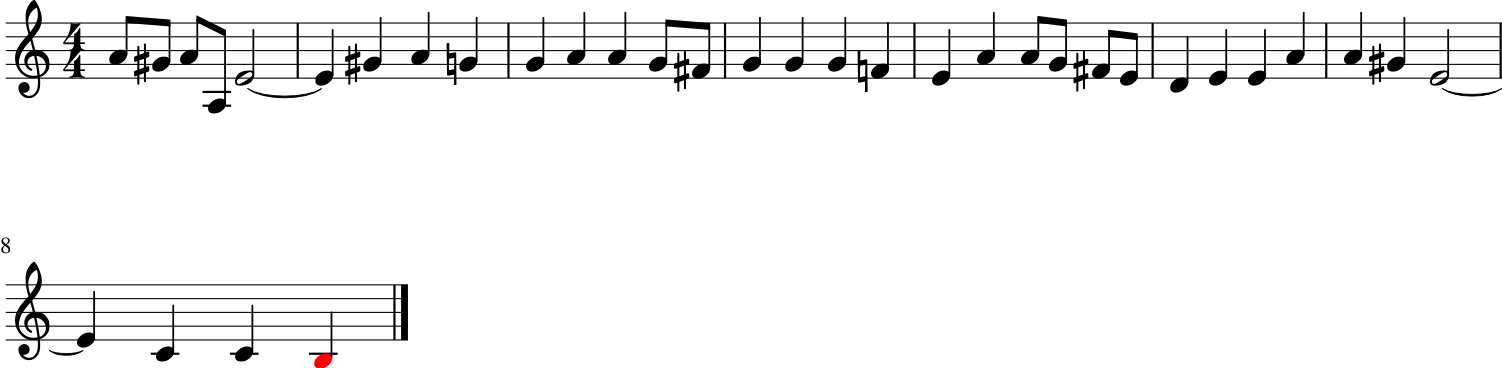

ambitus: 12


In [55]:
# check what the training data is compared to the thing to predict
i = random.randint(1, nn_inout2.shape[0])
ss = predtostream(nn_inout2[i,:,:])
nn = predbitfieldtonote(nn_inout2[i+1,0,:])
nn.color = 'red'
ss.append(nn)
ss.show()
print('ambitus:', ss.analyze('ambitus').semitones)

In [56]:
basicLossPlot = PlotLosses()


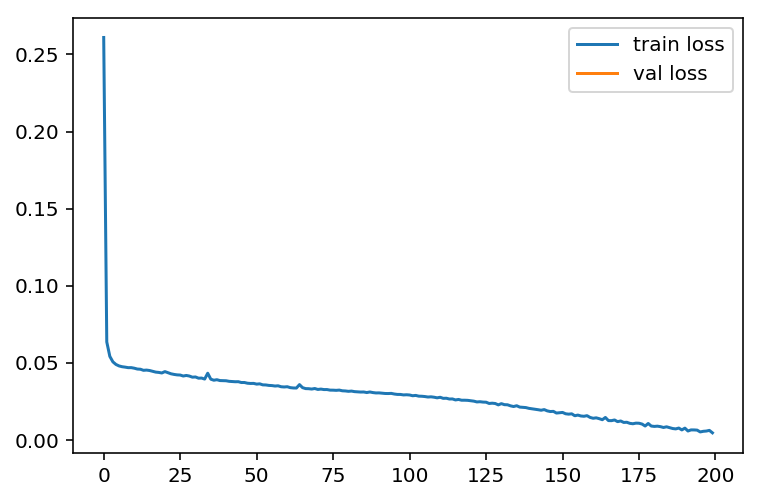

4074/4074 [==============================] - 0s - loss: 0.0046     


In [57]:
model.fit(nn_inout2[:-1,:,:], nn_inout2[1:,0,:], epochs=200, batch_size=512, callbacks=[basicLossPlot])

# End of note+duration train

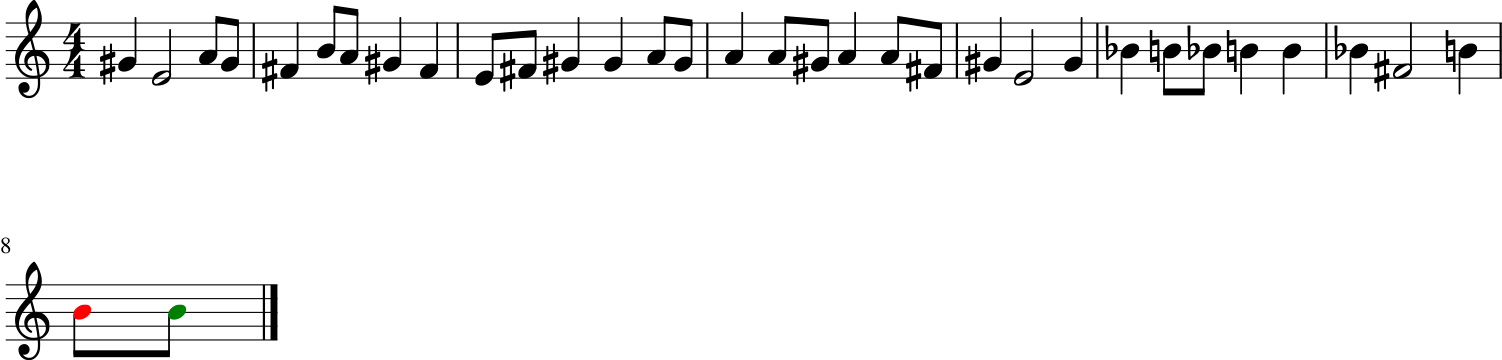

In [70]:
t = random.randint(1,nn_inout2.shape[0])
s = predtostream(nn_inout2[t])
n = predbitfieldtonote(model.predict(nn_inout2[t:t+1,:,:])[0])
n.color='red'
s.append(n)
c = predbitfieldtonote(nn_inout2[t+1,0,:])
c.color='green'
s.append(c)
s.show()

In [66]:
thresh = 0.8

# create a seed and predict stuff
t = random.randint(0,nn_inout2.shape[0]-1)
seed = nn_inout2[t:t+1,:,:]
print(seed.shape)

inp = seed
for i in range(128):
    p = model.predict(inp[:,-lookback:,:])
    p = cleanpred(p[0])
    inp = np.concatenate([inp,p[newaxis,newaxis,:]], axis=1)
    print('.', end='')
    
outp = inp[:,lookback:,:] # remove the seed
print(outp.shape)
output_notes = []
s = stream.Stream()
for i in range(len(outp[0])):
    n = predbitfieldtonote(outp[0,i],threshold=thresh)
    s.append(n)

(1, 32, 144)
................................................................................................................................(1, 128, 144)


In [60]:
s.write('midi', fp=f'output/test_output{datetime.now().strftime("%Y%m%d%H%M%S")}.mid')

'output/test_output20180308230851.mid'

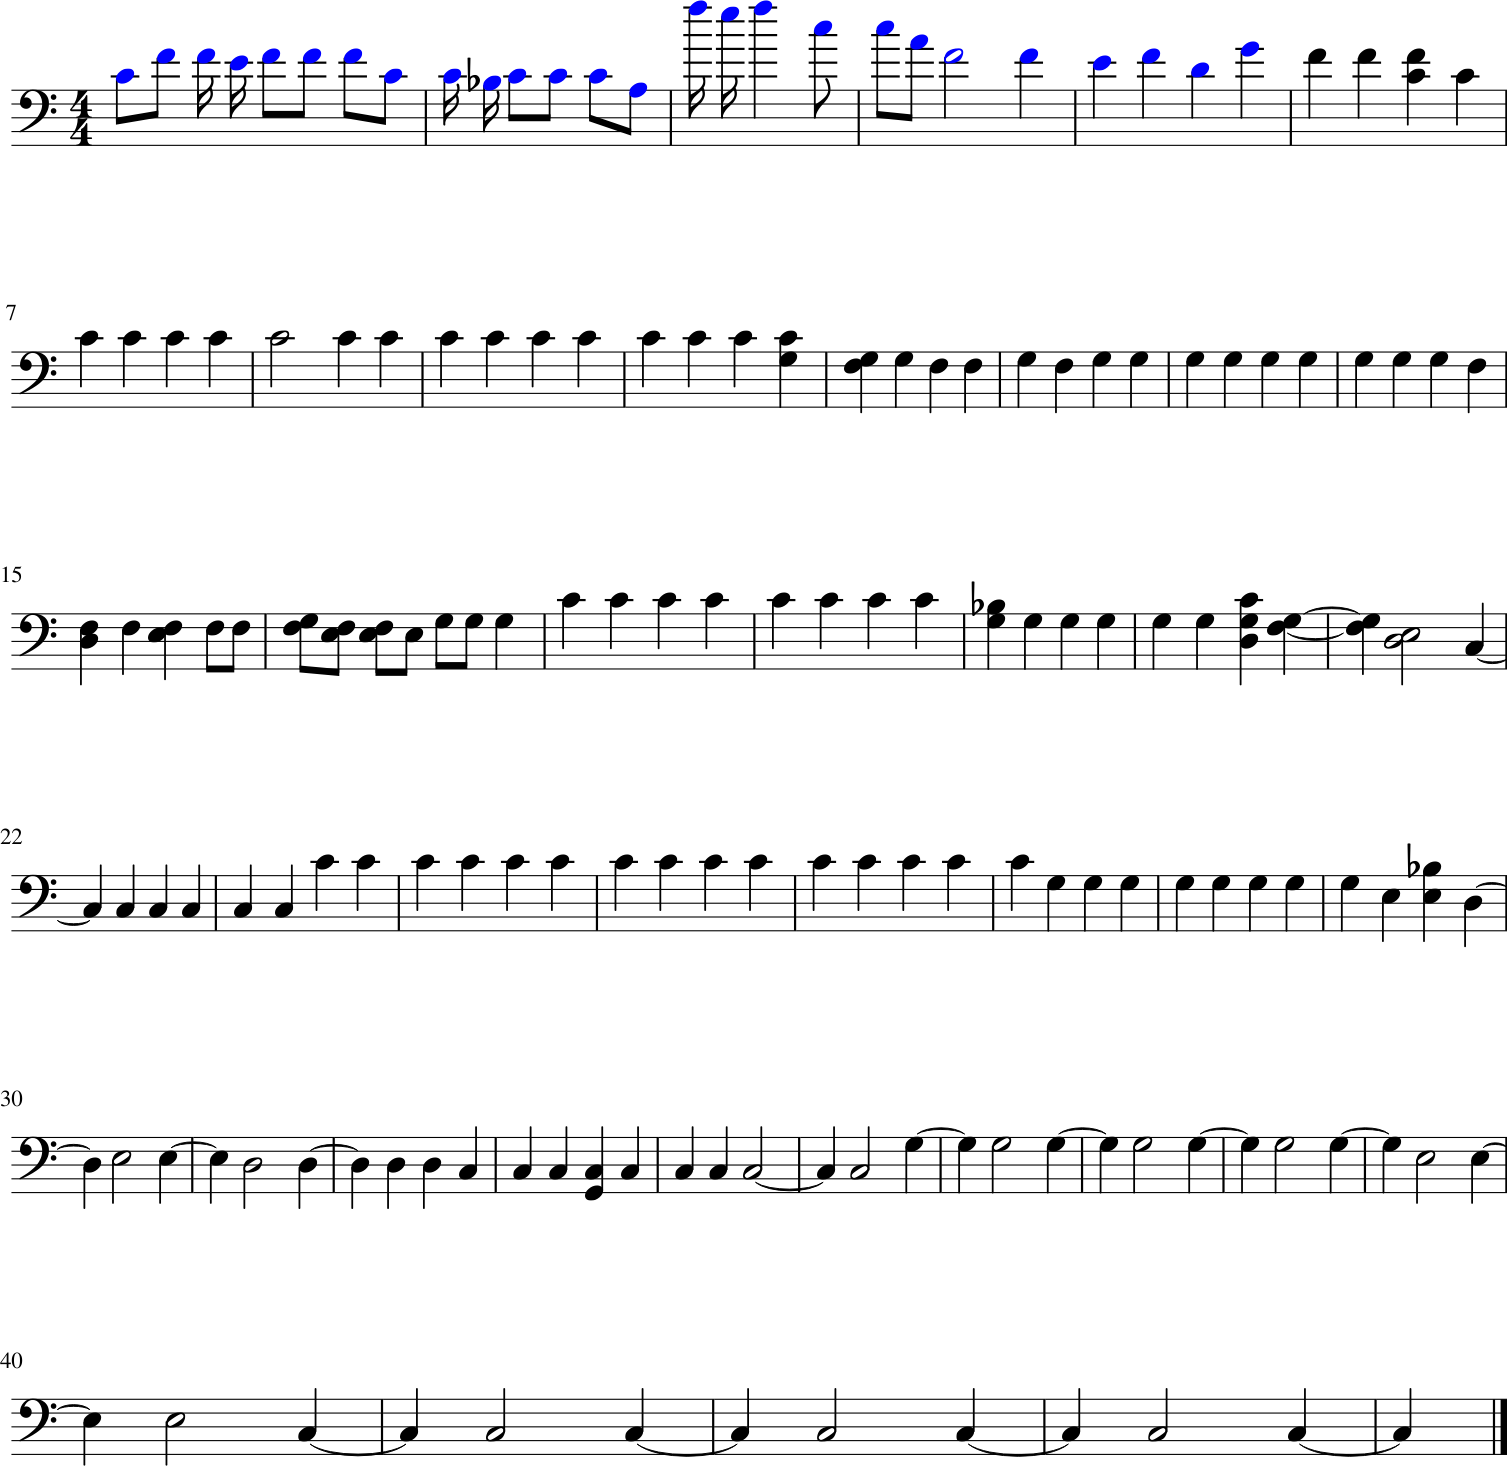

In [68]:
s = stream.Stream()
for i in range(len(inp[0])):
    n = predbitfieldtonote(inp[0,i],threshold=thresh)
    if i < lookback:
        n.color='blue'
    s.append(n)
s.show()

In [23]:
model.save_weights('weights-improvement-p3{datetime.now().strftime("%Y%m%d%H%M%S")}.hdf5')


# Third Model

In [30]:
inp = Input(shape=(lookback,nn_inout.shape[1],))
x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(nn_inout.shape[1]))(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 144)       0                                            
____________________________________________________________________________________________________
lstm_7 (LSTM)                    (None, 32, 256)       410624      input_3[0][0]                    
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 32, 256)       0           lstm_7[0][0]                     
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 32, 512)       1574912     dropout_7[0][0]                  
___________________________________________________________________________________________

In [32]:
# Add '0' at the end to make sure it fits blocks of 32
nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2.shape
nn_inout2 = nn_inout2.reshape(-1, lookback, 144)
nn_inout2.shape
nn_inout2 = np.concatenate([nn_inout2[:-1,:,:], nn_inout2[1:, 0:1, :]],axis=1)

(42016, 144)

(1313, 32, 144)

In [33]:
def predbitfieldtonote(pred, threshold=0.8):
#     print('x')
    t = np.max(pred[:n_vocab])*threshold
#     print(t)
    du = np.argmax(pred[n_vocab:])
    if np.argmax(pred)==0:
        n = note.Rest()
        n.duration.quarterLength = (du+1)/4
    else:
        nns = []
        for pp in np.where(pred[:n_vocab] > t)[0]:
#             print(pp)
            nn = note.Note()
            nn.pitch.midi = pp
            nns.append(nn)
        n = chord.Chord(nns)
        n.duration.quarterLength = (du+1)/4
    return n

def predtostream(pred):
    s = stream.Stream()
    for i in range(len(pred)):
        n = predbitfieldtonote(pred[i])
        s.append(n)
    return s

In [34]:
basicLossPlot = PlotLosses()


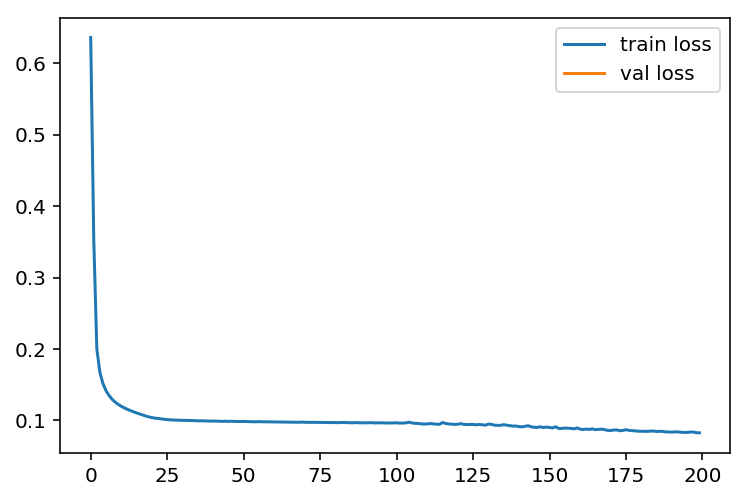

1311/1311 [==============================] - 0s - loss: 0.0824     


In [35]:
model.fit(nn_inout2[:-1,:32,:], nn_inout2[:-1,1:,:], epochs=200, batch_size=1024, callbacks=[basicLossPlot])

(1, 32, 144)

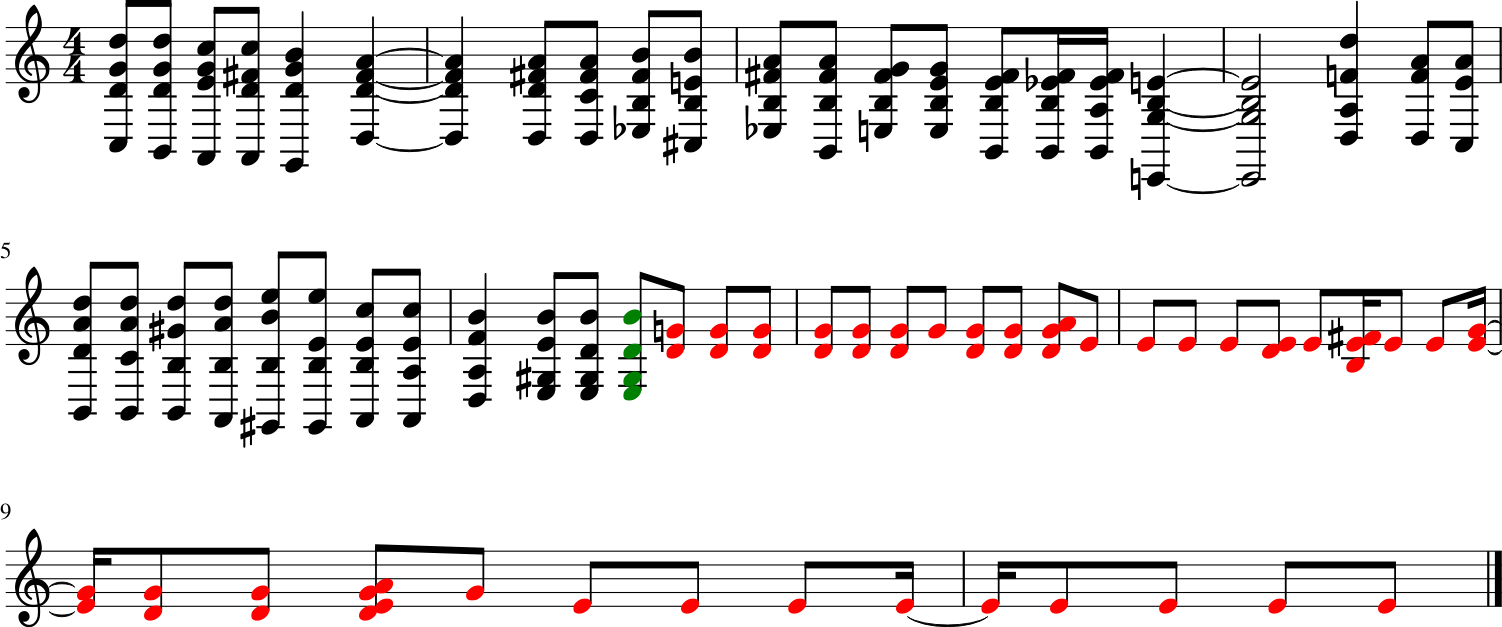

In [45]:
t = random.randint(1,nn_inout2.shape[0])
s = predtostream(nn_inout2[t])
c = predbitfieldtonote(nn_inout2[t+1,0,:])
c.color='green'
s.append(c)

x = model.predict(nn_inout2[t:t+1,:lookback,:])
x.shape
for i in range(x.shape[1]):
    n = predbitfieldtonote(x[0,i])
    n.color='red'
    s.append(n)
s.show()

In [36]:
thresh = 0.8

# create a seed and predict stuff
t = random.randint(0,nn_inout2.shape[0]-1)
seed = nn_inout2[t:t+1,:,:]
print(seed.shape)

inp = seed
for i in range(128):
    p = model.predict(inp[:,-lookback:,:])
    p = cleanpred(p[0,-1])
    inp = np.concatenate([inp,p[newaxis,newaxis,:]], axis=1)
    print('.', end='')
    
outp = inp[:,lookback:,:] # remove the seed
print(outp.shape)
output_notes = []
s = stream.Stream()
for i in range(len(outp[0])):
    n = predbitfieldtonote(outp[0,i],threshold=thresh)
    s.append(n)

(1, 33, 144)
................................................................................................................................(1, 129, 144)


In [37]:
s.write('midi', fp=f'output/test_output{datetime.now().strftime("%Y%m%d%H%M%S")}.mid')

'output/test_output20180308224946.mid'

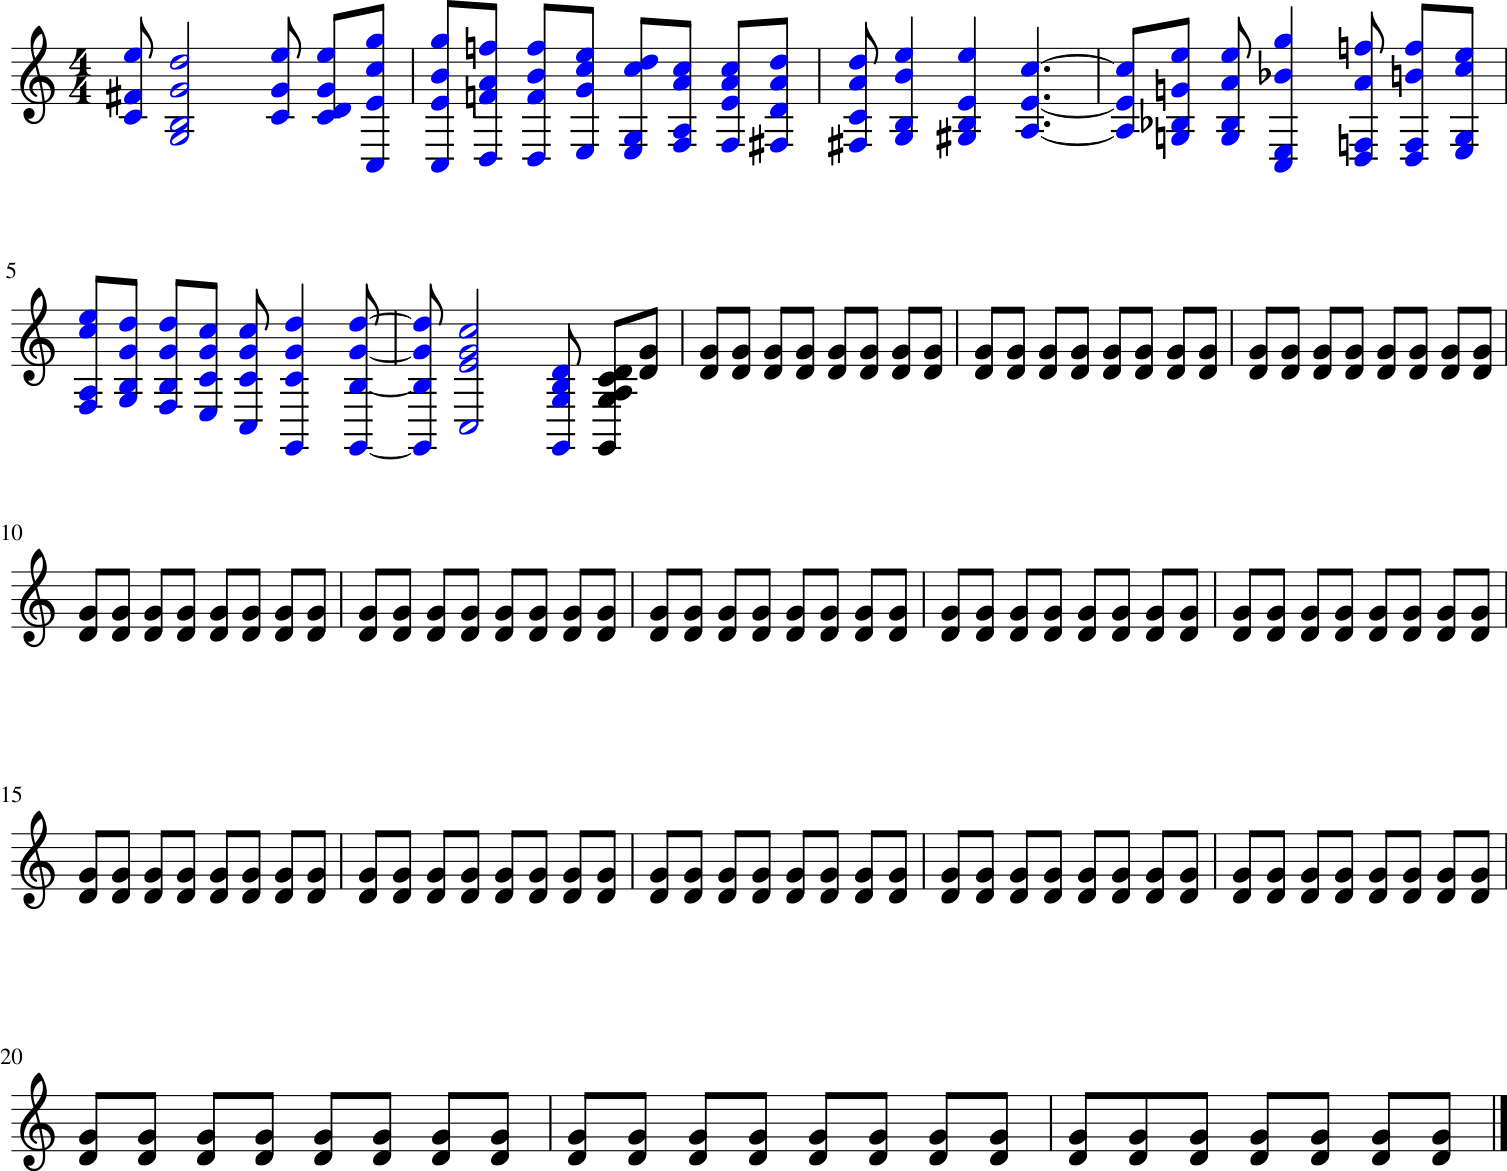

In [38]:
s = stream.Stream()
for i in range(len(inp[0])):
    n = predbitfieldtonote(inp[0,i],threshold=thresh)
    if i < lookback:
        n.color='blue'
    s.append(n)
s.show()

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')a

In [ ]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)   
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=200, batch_size=64, callbacks=callbacks_list)

In [ ]:
model.load_weights('weights-improvement-172-0.0521-bigger.hdf5')
# !ls -atl *bigger*

In [ ]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]

print('init', pattern.shape, len(pattern), pattern[0])
pattern = list(pattern.reshape(-1))
prediction_output = []
# generate 500 notes
for note_index in range(50):
    print('.', end ='')
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
#     print('>', pattern.shape, len(pattern), index)
#     pattern = list(pattern.reshape(-1))
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [ ]:
prediction_output

In [ ]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Saxophone()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Saxophone()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

In [ ]:
midi_stream.play()

In [ ]:
x = midi.realtime.StreamPlayer(midi_stream)
x.play()

In [ ]:
del x

# Second Model, PC

In [ ]:
n_vocab

In [ ]:
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], 2),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab+n_durations))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

In [ ]:
network_output.shape

In [ ]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)   
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=200, batch_size=64, callbacks=callbacks_list)

In [ ]:
model.load_weights('weights-improvement-172-0.0521-bigger.hdf5')
# !ls -atl *bigger*

In [ ]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]

print('init', pattern.shape, len(pattern), pattern[0])
pattern = list(pattern.reshape(-1))
prediction_output = []
# generate 500 notes
for note_index in range(50):
    print('.', end ='')
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
#     print('>', pattern.shape, len(pattern), index)
#     pattern = list(pattern.reshape(-1))
    pattern.append(index)
    pattern = pattern[1:len(pattern)]